In [1]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_keys(path):
    with open(path) as f:
        return f.readlines()[0]

In [3]:
def get_historical_stock_price(ticker, interval = None, startDate = None, endDate = None):
    url = 'https://api.unibit.ai/v2/stock/historical?'

    ticker_dict = {
        'tickers' : ticker,
        'interval' : interval,
        'startDate' : startDate,
        'endDate' : endDate,
        'selectedFields' : None,
        'dataType':'json',
        'accessKey': get_keys('C:\\Users\\TJ Bray\.secret\\unibit.txt')
    }
    
    response = requests.get(url, params = ticker_dict)
    data = response.json()['result_data'][ticker]
    df = pd.json_normalize(data)
    
    return df

In [4]:
#NKE = get_historical_stock_price('NKE', startDate = '2021-1-1', endDate = '2022-1-7')
#NKE.to_csv('nike.csv')

In [5]:
#nike = pd.read_csv('nike.csv', index_col = 0)
#nike.date = pd.to_datetime(nike.date)
#nike.set_index('date', inplace = True)
#nike.sort_index(inplace = True)

In [6]:
files = [f for f in listdir('.\Sp_500_data')]

In [7]:
companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)

In [8]:
test_companies = np.random.choice(companies, 5)

In [9]:
x = test_companies[0]

In [10]:
csv_for_df = f'sp_500_data/{x}.csv'
df = pd.read_csv(csv_for_df)
df.columns = [i.lower().replace(' ',"") for i in df.columns]

In [11]:
df['date'] = pd.to_datetime(df.date, format = '%d-%m-%Y')
df.set_index('date', inplace = True)
df.sort_index(inplace = True)

In [12]:
df['rsi'] = ta.rsi(df.close)

In [13]:
def add_bbands(df):
    bbands = ta.bbands(df.close)
    df = df.join(bbands)
    return df

In [14]:
bbands_df = add_bbands(df)

In [15]:
def add_sma(df):
    
    sma_days = [7,22,50,252]
    
    for i in sma_days:
        name = f'sma{i}'
        df[name] = ta.sma(df['close'],i)
        
    return df

In [16]:
sma_df = add_sma(bbands_df)

In [17]:
def add_ema(df):

    ema_days = [7,22,50,252]

    for i in ema_days:
        name = f'ema{i}'
        df[name] = ta.ema(df['close'],i)
        
    for i in ema_days:
        zone_name = f'ema{i}zone'
        df[zone_name] = ta.ema(df.high,i) - ta.ema(df.low,i)
        
    return df

In [18]:
ema_df = add_ema(sma_df)

In [19]:
df = ema_df

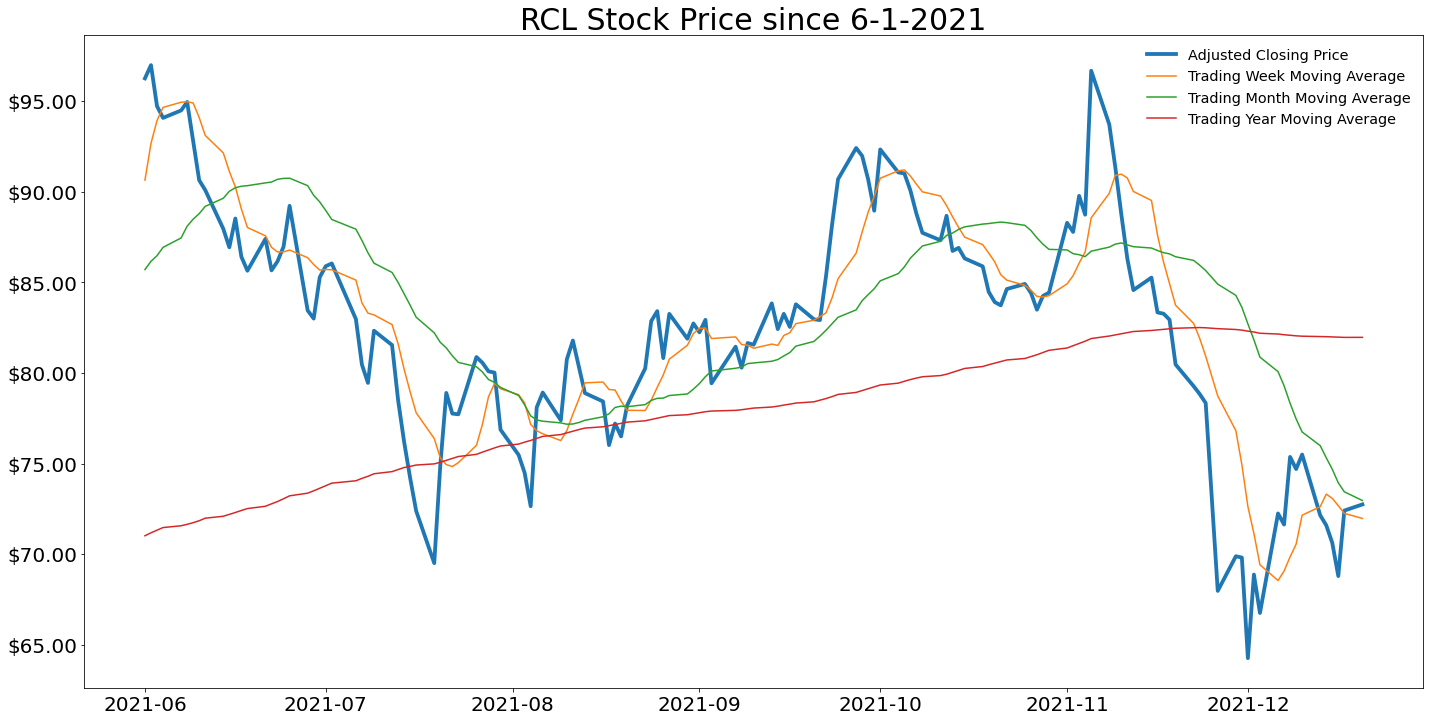

In [20]:
date = '6-1-2021'
title = f'{x} Stock Price since {date}'

plotdata = df[df.index >= date]
fig, ax = plt.subplots(figsize = (24,12))
ax.plot(plotdata.adjustedclose, linewidth = 3.8)
ax.plot(plotdata.sma7)
ax.plot(plotdata.sma22)
ax.plot(plotdata.sma252)
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.legend(['Adjusted Closing Price', 'Trading Week Moving Average', 'Trading Month Moving Average', 'Trading Year Moving Average'],
         fontsize = 'x-large', edgecolor = '1')
ax.set_title(title, fontsize = '30')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')

plt.show()

In [21]:
#Explain Bollinger Bands and Importance

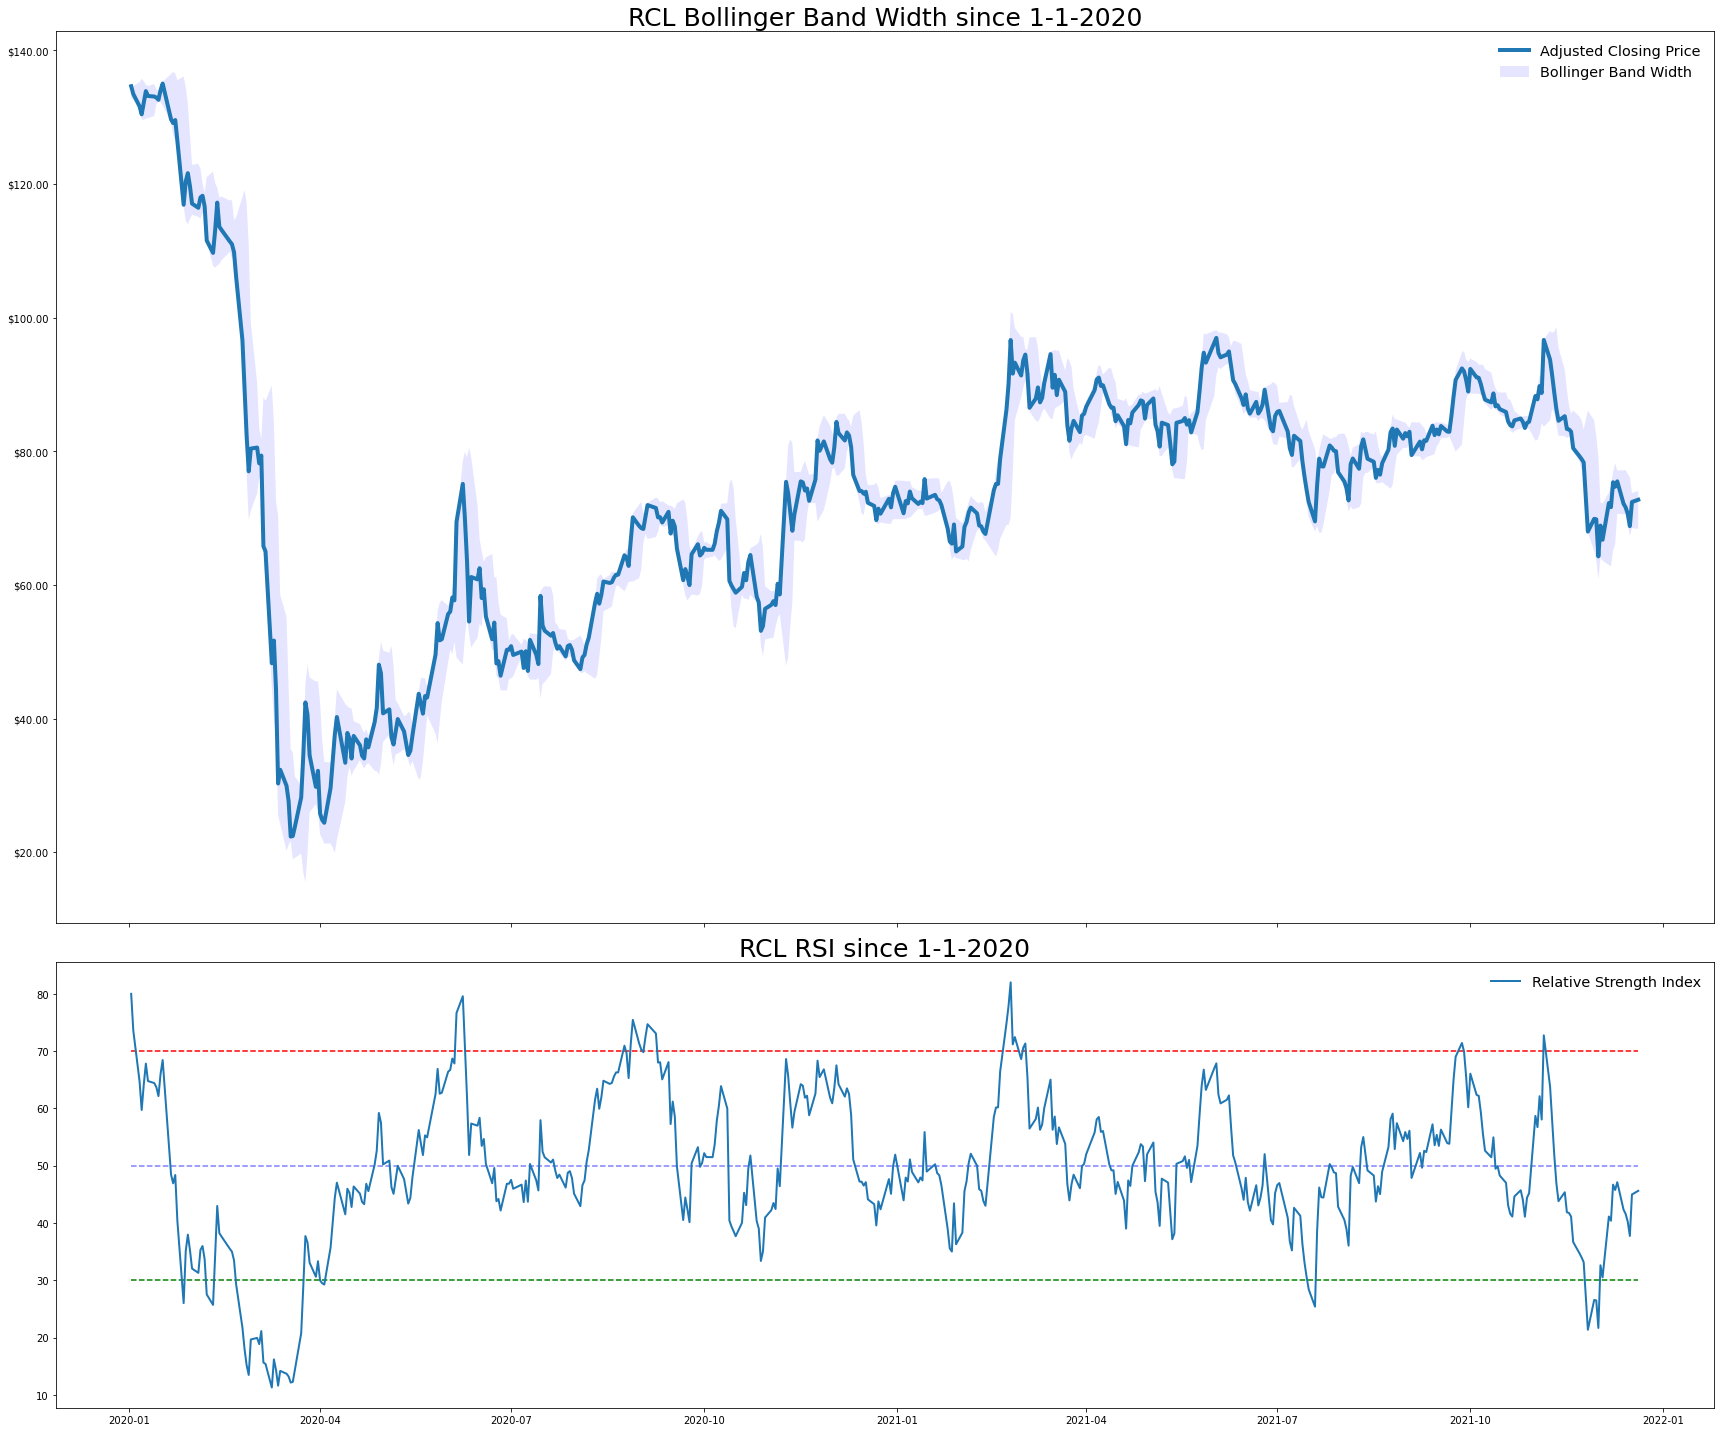

In [22]:
date = '1-1-2020'
title1 = f'{x} Bollinger Band Width since {date}'
title2 = f'{x} RSI since {date}'
plotdata = df[df.index >= date]

fig, (ax1, ax2) = plt.subplots(2, figsize = (24,20), sharex = True, gridspec_kw = {'height_ratios': [2,1]})
ax1.plot(plotdata.close, linewidth = 4)
ax1.fill_between(plotdata.index, plotdata['BBL_5_2.0'], plotdata['BBU_5_2.0'], facecolor = 'blue', alpha = .1)
ax1.yaxis.set_major_formatter('${x:1,.2f}')
ax1.legend(['Adjusted Closing Price', 'Bollinger Band Width'],
         fontsize = 'x-large', edgecolor = '1')
ax1.set_title(title1, fontsize = '25')

ax2.plot(plotdata.rsi, linewidth = 2)
ax2.hlines(y=70, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'red')
ax2.hlines(y=50, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = .5, color = 'blue')
ax2.hlines(y=30, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'green')
ax2.legend(['Relative Strength Index'],
         fontsize = 'x-large', edgecolor = '1')
ax2.set_title(title2, fontsize = '25')

plt.tight_layout()
plt.show()

In [23]:
#Explain RSI and Importance

In [24]:
#lags = [1,2,3,4,5,10]

#for i in lags:
#    lag_time = f'closelag{i}'
#    df[lag_time] = df['adjustedclose'].shift(i)

In [25]:
df['day_direction'] = np.where(df['adjustedclose'] > df['adjustedclose'].shift(1),1,0)

In [26]:
df['golden_crossover_short'] = np.where((df['ema50'] < df['ema7']) & (df['ema50'].shift(1) > df['ema7'].shift(1)),1,0) 

In [27]:
df['death_crossover_short'] = np.where((df['ema50'] > df['ema7']) & (df['ema50'].shift(1) < df['ema7'].shift(1)),1,0) 

In [28]:
df['golden_crossover_long'] = np.where((df['ema252'] < df['ema50']) & (df['ema252'].shift(1) > df['ema50'].shift(1)),1,0) 

In [29]:
df['death_crossover_long'] = np.where((df['ema252'] > df['ema50']) & (df['ema252'].shift(1) < df['ema50'].shift(1)),1,0) 

In [30]:
df['RSI_overbought_cross'] = np.where((df['rsi'] >= 70) & (df['rsi'].shift(1) < 70),1,0)

In [31]:
df['RSI_oversold_cross'] = np.where((df['rsi'] <= 30) & (df['rsi'].shift(1) > 30),1,0)

In [32]:
df['RSI_overbought'] = np.where(df['rsi'] >= 70,1,0)

In [33]:
df['RSI_oversold'] = np.where(df['rsi'] <= 30,1,0)

In [34]:
df['momentum'] = ta.mom(df['adjustedclose'])

In [35]:
market_data = pd.read_csv('marketsentiment.csv', index_col = 0)

In [36]:
df = df.join(market_data, rsuffix = '_macro')

In [37]:
df.dropna(inplace = True)

In [38]:
corrs = df.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [39]:
correlations['1'].value_counts()

adjustedclose    9
BBU_5_2.0        9
close            9
BBM_5_2.0        9
sma252           8
sma7             8
ema7             7
ema252           7
high             7
ema22            7
dspic            7
BBL_5_2.0        6
low              6
sma22            6
ema50            6
sp500_ema_252    5
m2               5
ccpi             4
open             4
sma50            4
ema252zone       4
sp500_ema_50     3
ema50zone        3
sp500_ema_22     3
sp500_close      2
sp500_ema_7      2
ema7zone         1
ema22zone        1
ffer             1
Name: 1, dtype: int64

In [40]:
df2 = df.drop(['sma252','sma50','ema22zone','ema252zone', 'ema50', 'BBU_5_2.0', 
               'ema7zone', 'sma22', 'ema50zone', 'BBL_5_2.0', 'BBM_5_2.0', 
               'ema22', 'sma7','ema252', 'dspic', 'sp500_ema_252', 'sp500_close',
              'ccpi', 'sp500_ema_7', 'sp500_ema_22', 'sp500_ema_50','m2'],axis = 1)

In [41]:
corrs2 = df2.corr().stack().reset_index()
corrs2.columns = ['1','2','R2']
temp2 = corrs2[(corrs2.R2 > .8) & (corrs2.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations2 = temp2[temp2.index % 2 == 0]

In [42]:
correlations2['1'].value_counts()

adjustedclose    4
low              3
ema7             2
open             2
high             1
Name: 1, dtype: int64

In [43]:
df2.columns

Index(['low', 'open', 'volume', 'high', 'close', 'adjustedclose', 'rsi',
       'BBB_5_2.0', 'BBP_5_2.0', 'ema7', 'day_direction',
       'golden_crossover_short', 'death_crossover_short',
       'golden_crossover_long', 'death_crossover_long', 'RSI_overbought_cross',
       'RSI_oversold_cross', 'RSI_overbought', 'RSI_oversold', 'momentum',
       'psr', 'ir', 'ffer', 'sp500_return', 'sp500_BBB_5_2.0',
       'sp500_BBP_5_2.0'],
      dtype='object')

In [44]:
csv_name = f'FormattedData/{x}_formatted.csv'
df2.to_csv(csv_name)